<a href="https://colab.research.google.com/github/graphlit/graphlit-evals/blob/main/tonic-validate/Tonic_Validate_Graphlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
!pip install --upgrade tonic_validate

In [124]:
!pip install --upgrade graphlit-client

In [125]:
import os
from typing import Optional
from tonic_validate import ValidateScorer, Benchmark, BenchmarkItem, LLMResponse, BenchmarkItem, Run
from tonic_validate.metrics import AnswerSimilarityMetric
from concurrent.futures import ThreadPoolExecutor
import os
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import userdata

In [126]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# configure shared, writable folder containing sample data
tonic_validate_directory = "/content/drive/MyDrive/Colab Notebooks/Tonic Validate"

Mounted at /content/drive


Initialize Graphlit

In [127]:
from graphlit import Graphlit
from graphlit_api import input_types, enums, exceptions

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

os.environ['GRAPHLIT_ORGANIZATION_ID'] = userdata.get('GRAPHLIT_ORGANIZATION_ID')
os.environ['GRAPHLIT_ENVIRONMENT_ID'] = userdata.get('GRAPHLIT_ENVIRONMENT_ID')
os.environ['GRAPHLIT_JWT_SECRET'] = userdata.get('GRAPHLIT_JWT_SECRET')

graphlit = Graphlit()

Load benchmark questions & answers

In [128]:
with open(f"{tonic_validate_directory}/Sample Data/qa_pairs.json", "r") as f:
    qa_pairs = json.load(f)

# for testing
qa_pairs = qa_pairs

benchmark = Benchmark(
    questions=[x["question"] for x in qa_pairs],
    answers=[x["answer"] for x in qa_pairs]
)

def run_to_dataframe(run: Run) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "reference_question": [x.reference_question for x in run.run_data],
            "reference_answer": [x.reference_answer for x in run.run_data],
            "llm_answer": [x.llm_answer for x in run.run_data],
            "llm_context": [json.dumps(x.llm_context) for x in run.run_data],
            "answer_similarity": [x.scores["answer_similarity"] for x in run.run_data]
        }
    )

Define Graphlit helper functions

In [129]:
import asyncio
import time
from datetime import datetime

async def upload_graphlit_essays():
    directory = f"{tonic_validate_directory}/Sample Data/paul_graham_essays"

    response = await graphlit.client.create_collection(input_types.CollectionInput(name="Paul Graham Essays"))

    collection_id = response.create_collection.id if response.create_collection is not None else None

    if collection_id is not None:
        file_paths = [os.path.join(directory, filename)
                    for filename in os.listdir(directory)
                    if os.path.isfile(os.path.join(directory, filename))]

        start_time = time.time()

        tasks = []
        for file_path in file_paths:
            file_name = os.path.basename(file_path)
            content_name, _ = os.path.splitext(file_name)

            with open(file_path, "r", encoding='utf-8') as file:
                file_content = file.read()

            task = graphlit.client.ingest_text(content_name, file_content, text_type=enums.TextTypes.PLAIN,
                is_synchronous=True, collections=[input_types.EntityReferenceInput(id=collection_id)])
            tasks.append(task)

        results = await asyncio.gather(*tasks)

        duration = time.time() - start_time

        current_time = datetime.now()
        formatted_time = current_time.strftime("%H:%M:%S")

        print(f"Uploading essays took {duration:.2f} seconds. Finished at {formatted_time} UTC.")

        return collection_id
    else:
        return None

async def create_specification():
    input = input_types.SpecificationInput(
        name="Completion",
        type=enums.SpecificationTypes.COMPLETION,
        serviceType=enums.ModelServiceTypes.OPEN_AI,
        openAI=input_types.OpenAIModelPropertiesInput(model=enums.OpenAIModels.GPT4_TURBO_128K),
        searchType=enums.ConversationSearchTypes.VECTOR,
        numberSimilar=25,
        retrievalStrategy=input_types.RetrievalStrategyInput(
            type=enums.RetrievalStrategyTypes.CHUNK,
            contentLimit=10,
        ),
        rerankingStrategy=input_types.RerankingStrategyInput(
            serviceType=enums.RerankingModelServiceTypes.COHERE
        )
    )

    try:
        response = await graphlit.client.create_specification(input)

        return response.create_specification.id if response.create_specification is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

# NOTE: for cleaning up project data
async def delete_all_collections():
    _ = await graphlit.client.delete_all_collections()

    print('Deleted all collections.')

async def delete_all_contents():
    _ = await graphlit.client.delete_all_contents()

    print('Deleted all contents.')

Define Graphlit RAG function

In [130]:
async def get_graphlit_rag_response(benchmarkItem: BenchmarkItem, specification_id: str, collection_id: str):
    prompt = benchmarkItem.question

    input = input_types.ConversationInput(name="Conversation", specification=input_types.EntityReferenceInput(id=specification_id),
        filter=input_types.ContentCriteriaInput(collections=[input_types.EntityReferenceInput(id=collection_id)]))

    response = await graphlit.client.create_conversation(input)

    conversation_id = response.create_conversation.id if response.create_conversation is not None else None

    if conversation_id is None:
        print('Failed to create conversation.')
        return None

    print(f'Created conversation [{conversation_id}].')

    try:
        response = await graphlit.client.prompt_conversation(prompt, conversation_id)

        message = response.prompt_conversation.message if response.prompt_conversation is not None else None

        return message
    finally:
        _ = await graphlit.client.delete_conversation(conversation_id)

Initialize Graphlit test

In [131]:
# NOTE: this will delete all contents and collections in project
await delete_all_contents()
await delete_all_collections()

# Initialize specification
specification_id = await create_specification()

if specification_id is not None:
    print(f'Created specification [{specification_id}].')
else:
    print('Failed to create specification.')

INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"


Deleted all contents.


INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"


Deleted all collections.


INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"


Created specification [226708b4-e10c-4b40-a7a3-f58726008423].


In [132]:
# Upload all essays
collection_id = await upload_graphlit_essays()

print(f'Essays ingested into collection [{collection_id}].')

INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/

Uploading essays took 37.97 seconds. Finished at 08:32:21 UTC.
Essays ingested into collection [0d9f47b9-3614-4144-b216-e780e7f88916].


Validate Graphlit response

In [133]:
benchmark_item = BenchmarkItem(
    question="What key components are necessary to create a technology hub according to Paul Graham?",
    answer=""
)

if collection_id is not None and specification_id is not None:
    message = await get_graphlit_rag_response(benchmark_item, specification_id, collection_id)

    if message is not None:
        print(message.message)
        print(f'Tokens: {message.tokens}, took [{message.completion_time}]')

INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"


Created conversation [e554201a-8f98-4c7e-9214-6e3474c1c70d].


INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"


According to Paul Graham, several key components are necessary to create a technology hub. First, the presence of 'rich people and nerds' is crucial as they are the primary actors in the startup ecosystem. Rich people provide the necessary capital, while nerds contribute the innovative ideas and technical expertise. Second, a first-rate university is essential, acting as a magnet to attract top talent and foster a culture of innovation. This university should ideally be comparable to institutions like MIT or Stanford, which have historically been central to the development of tech hubs like Silicon Valley.

Additionally, an environment that encourages startups is vital. This includes having a high density of people interested in startups, which increases the likelihood of chance meetings and collaborations that are crucial for innovation. The social atmosphere should also be conducive to taking ambitious risks, often characterized by a sense of optimism and a lack of restrictive norms 

Perform Graphlit test and score run

In [134]:
import asyncio

async def run_test(specification_id, collection_id):
    tasks = []
    for item in benchmark.items:
        task = get_graphlit_rag_response(item, specification_id, collection_id)
        tasks.append(task)

    return await asyncio.gather(*tasks)

messages = await run_test(specification_id, collection_id)

raw_graphlit_responses = []

for message in messages:
    raw_graphlit_responses.append(message.message.strip())

INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"


Created conversation [e502ccdb-d031-4ecc-a9cc-f06878a6938a].


INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"


Created conversation [12e5d001-d246-4a5f-a958-cf1b47eb1f7f].
Created conversation [9ae9778d-ef90-4b9c-8f33-947271e33a9f].


INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"


Created conversation [efb57246-d776-4b78-bbae-3e0b8a060f29].


INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/

Created conversation [2cfbe8b6-585e-4b50-a698-4ed3e8912cfa].
Created conversation [c946a3db-f0e6-4a71-9d9a-a19cfd0b875f].
Created conversation [5d3ae86b-06fa-4b1a-b953-12e0550479f2].
Created conversation [c7766f5c-5f68-4dbc-8f65-5ea70899e5b6].
Created conversation [bbdd6e99-58ce-4e0d-9636-04d722eb921a].
Created conversation [1007b8a4-346c-4e93-b760-0ed6d96448d5].
Created conversation [75e105e9-966d-435c-b768-6b4cab23bdc0].
Created conversation [e765d38b-d637-4fa6-909f-ef34e2da922d].
Created conversation [d34c07da-448a-43e1-a676-112157434e3c].
Created conversation [4f849bd6-a093-48a7-9dea-00fa21fd1c8b].
Created conversation [bc09f246-ed4d-427b-a1ce-bb78c6777bf4].
Created conversation [2ed04d10-7ff7-494e-9e91-3919086f3334].
Created conversation [1a399129-4f69-450a-a3ae-f10c4578611b].
Created conversation [c8ccdf6c-aa74-45d6-a245-fc3e1da4888f].
Created conversation [6a322fc6-bf2a-4bf2-bb20-8fc95cb32c7a].
Created conversation [7b8ce7d3-7163-4484-bc06-5e51c5235d21].


INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/

Created conversation [d603b4c7-4f5b-4790-9b48-4695e6e2971a].
Created conversation [901c7d4e-d09b-4fe3-a1d7-390a6095f84f].
Created conversation [6a0ea0d8-bc46-4e91-baf7-77d7fb49f628].
Created conversation [407fba83-b72a-4084-ba09-c15311b4ea2d].
Created conversation [65b61a0c-8276-49fd-8d86-b373f7779f01].
Created conversation [19518e70-9586-492c-9f1b-3ccc7e51d437].
Created conversation [44b0b9dd-edb8-4bd9-9234-4a660707e22e].
Created conversation [f1d69ae3-27b8-4170-8c4a-9bfe414e19aa].
Created conversation [0a615ad8-ce49-4d2a-9e02-c4c7673472a3].
Created conversation [35e23004-a1ed-40bf-b5c6-7e490f7efbf3].
Created conversation [e495f7b9-643d-4aa3-8921-21fadf34dd23].
Created conversation [bda7addf-5b8f-4672-b5af-fb32cb8e8451].
Created conversation [bf4cabfe-a5f4-4e13-a865-f2b2483c4af5].
Created conversation [799bc2dc-423b-4c2a-88c0-b381fad8dfb6].
Created conversation [babe89fd-a1ad-42be-844c-2dcd9d39ac33].
Created conversation [e384446f-a7aa-4a69-8d26-a051ade9d403].
Created conversation [45

INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/

Created conversation [7280fac7-850f-4e42-b9b7-c0b2a65b29f4].
Created conversation [bc9a3436-be93-4dc2-ba86-880653c21480].
Created conversation [792e345b-d667-4043-a251-de76c2c4ac2f].
Created conversation [8dd592ef-4575-484e-9128-9fafe8c3428e].
Created conversation [9806da56-6a82-4431-86a9-172011c66643].
Created conversation [25daa94e-fe41-4881-901e-02efd910b00b].
Created conversation [df6c261f-c7b7-4f53-9919-4fcbdfc5cf9c].
Created conversation [28fd5d8b-3333-4666-8df5-a735af6f90a3].
Created conversation [3e30441d-b87a-440d-b2fb-3560c561a01a].
Created conversation [d300cbe5-8d91-4167-befd-8bdacc298f4c].
Created conversation [5ec2d038-d1a3-4b3e-9087-39286df058a7].
Created conversation [6c8ecb64-e63f-469f-b3c6-96e0aa8d9f42].


INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/api/v1/graphql/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://data-scus.graphlit.io/

In [135]:
graphlit_responses = [
    LLMResponse(
        llm_answer=r, llm_context_list=[], benchmark_item=bi
    ) for r, bi in zip(raw_graphlit_responses, benchmark.items)
]

In [136]:
scorer = ValidateScorer(model_evaluator="gpt-4-turbo", metrics=[AnswerSimilarityMetric()])
graphlit_run = scorer.score_run(graphlit_responses, parallelism=5)

Scoring responses:   2%|▏         | 1/55 [00:00<00:35,  1.51it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring responses:   5%|▌         | 3/55 [00:00<00:11,  4.72it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring responses:   9%|▉         | 5/55 [00:00<00:06,  7.46it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring responses:  13%|█▎        | 7/55 [00:01<00:08,  5.39it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:H

In [137]:
graphlit_run_df = run_to_dataframe(graphlit_run)
graphlit_run_df.to_csv(f"{tonic_validate_directory}/graphlit_run.csv", index=False)

Visualize Graphlit test

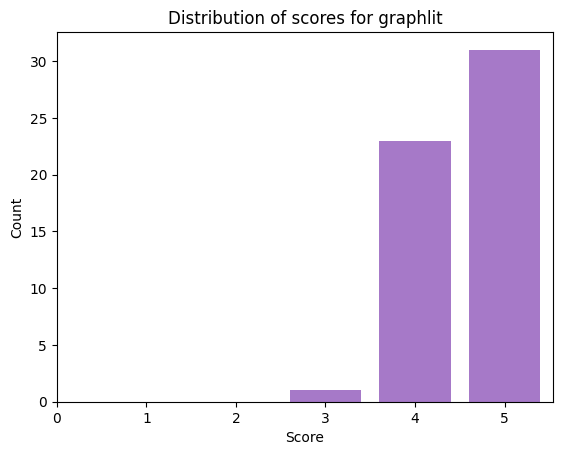

In [138]:
graphlit_answer_similarity_scores = pd.Series([x.scores["answer_similarity"] for x in graphlit_run.run_data])
category_counts = graphlit_answer_similarity_scores.value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for graphlit')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()